### LEFT SMEFT Comparisons
This notebook compares the SMEFT distribution vs the operator matched LEFT model

### Imports

In [16]:
import sys
sys.path.append("/Users/mistryk2/Packages/nudobe/src/")
sys.path.append("/Users/mistryk2/Packages/nudobe/")

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from nudobe import EFT
from EFT import LEFT

from nudobe import constants, functions
from constants import *

#import neutrino mixing matrix function
from functions import U_PMNS

#import multiprocessing

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D


import matplotlib.cm as cm
import time

### Setup mLRSM

In [17]:
def get_masses(m_min           = 0, 
                ordering        = "NO", 
                Majorana_phases = [0,0], 
                v_R             = 10*TeV, 
                v_L             = 0.1*eV, 
                m_heavy         = np.array([10,12,13])*TeV,
                theta_L         = 0,
               ):
    U = U_PMNS(alpha=Majorana_phases)
    m = m_min
    
    if ordering == "NO" or ordering == "NH":
        m1 = m
        m2 = np.sqrt(m1**2+m21)
        m3 = np.sqrt(m2**2+m32)
    elif ordering == "IO" or ordering == "IH":
        m3 = m
        m2 = np.sqrt(m3**2-m32IO)
        m1 = np.sqrt(m2**2-m21)

    
    #diagonal light neutrino masses
    m_nu = np.diag([m1,m2,m3])*1e-9
    
    #diagonal heavy neutrino masses
    m_nu_R = np.diag(m_heavy)
    
    #non-diagonal light neutrino mass
    M_nu = U@m_nu@U.T
    
    #non-diagonal heavy neutrino mass
    M_nu_R = U@m_nu_R@U.T
    
    #inverse matrices
    M_nu_R_inv = np.linalg.inv(M_nu_R)
    
    M_nu_R_dagger_inv = np.linalg.inv(M_nu_R.T.conjugate())
    
    #non-diagonal yukawa matrices
    M_R = M_nu_R.T.conjugate()/(np.sqrt(2)*v_R)
    M_L = M_R.T.conjugate()
    
    M_nu_L = (np.sqrt(2) * v_L * np.exp(1j*theta_L) * M_L)
    
    #get the dirac yukawa matrix eq.57
    M_nu_D = U@m_nu_R@scipy.linalg.sqrtm(v_L/v_R*np.exp(1j*theta_L) * np.diag([1,1,1])
                                                          - np.linalg.inv(m_nu_R)@m_nu+0j)@U.T
    #return results
    return(m_nu, m_nu_R, M_nu_R, M_nu_R_inv, M_nu_R_dagger_inv, M_nu_D, M_nu_L)


# Gets the Wilson Coeficients at SMEFT
def GetWCs_mLRSM(m_min, v_R, v_L, m_heavy, theta_L, xi):
      m_nu, m_nu_R, M_nu_R, M_nu_R_inv, M_nu_R_dagger_inv, M_nu_D, M_nu_L = get_masses(
                                                                                    m_min           = 0, 
                                                                                    ordering        = "NO", 
                                                                                    Majorana_phases = [0,0], 
                                                                                    v_R             = v_R, 
                                                                                    v_L             = v_L, 
                                                                                    m_heavy         = m_heavy,
                                                                                    theta_L         = theta_L,
                                                                                    )


      # SMEFT
      C5         = 1/vev**2 * (M_nu_D.T@M_nu_R_inv@M_nu_D-M_nu_L)[0,0]
      C_LeudPhi7 = np.sqrt(2)/vev * (1/v_R**2 *(V_ud_R.conjugate()) * M_nu_D.T@M_nu_R_inv)[0,0]
      C_LPhiDe7  = 2j * xi*np.exp(1j * alpha) / (1 + xi**2) * C_LeudPhi7 / V_ud_R.conjugate()
      C_eeud9    = 0.88 * (-1 / (2 * v_R**4) * V_ud_R**2 * (M_nu_R_dagger_inv + 2 / m_DR**2 * M_nu_R))[0,0]
      C_eePhiud9 = -4 * (xi * np.exp(-1j * alpha)) / (1 + xi**2) * C_eeud9/V_ud_R
      C_eePhiD9  = 4 * xi**2 * np.exp(-2j * alpha) / ((1 + xi**2)**2) * C_eeud9/V_ud_R**2

      return {"LH(5)"      : C5, 
            "LeudH(7)"   : C_LeudPhi7, 
            "LHDe(7)"    : C_LPhiDe7, 
            "ddueue(9)"  : 4*np.conj(C_eeud9), 
            "deueH2D(9)" : -2 * np.conj(C_eePhiud9), 
            "eeH4D2(9)"  : -np.conj(C_eePhiD9)
            }

# Matches SMEFT wilson coeficients down to m_W scale using Table in Appendix A and Matching scheme in Appendix B
def GetWCsLEFT_mLRSM(m_min, v_R, v_L, m_heavy, theta_L, xi):
      SMEFT_WCs = GetWCs_mLRSM(0, v_R, v_L, m_heavy, theta_L, xi)

      m_bb   = -vev**2 * SMEFT_WCs["LH(5)"]
      C_VR6  = (vev**3/np.sqrt(2)) * SMEFT_WCs["LeudH(7)"].conjugate()
      C_VL6  = - (vev**3 * 1j) /np.sqrt(2) *V_ud * SMEFT_WCs["LHDe(7)"].conjugate()
      C_1R9p = - (vev**5 / 4) *  SMEFT_WCs["ddueue(9)"].conjugate()
      C_4R9  = -vev**5 * (V_ud/2) * SMEFT_WCs["deueH2D(9)"].conjugate()
      C_1R9  = -vev**5 * (V_ud/2) * SMEFT_WCs["eeH4D2(9)"].conjugate()

      return {
            "m_bb"       : m_bb,
            "VR(6)"      : C_VR6,
            "VL(6)"      : C_VL6,
            "1R(9)prime" : C_1R9p,
            "4R(9)"      : C_4R9,
            "1R(9)"      : C_1R9
      }



In [18]:
#Parameters

# ------- mLRSM ---------
#masses
v_R  = 10*TeV
v_L  = 0.1*eV
m_DR = 4*TeV

#heavy neutrino masses
m_heavy = np.array([10,12,13])*TeV

#mixings
V_ud_R  = V_ud
V_ud_L  = V_ud
xi      = m_b/m_t
theta_L = 0
alpha   = 0

# Get the Dark2 colormap
cmap = cm.get_cmap('Dark2')

nbins = 100
eps = 1e-5 #avoid poles
nevts = 100000

Q = 2.457984 # Q-value in MeV units
me = 0.51099895 # electron mass in MeV units


# Define nu_L and xi for each model
Params = []
Params.append({"v_L":0.1*eV, "xi": m_b/m_t})
Params.append({"v_L":0.1*eV, "xi": 0})
Params.append({"v_L":100*eV, "xi": m_b/m_t})
Params.append({"v_L":100*eV, "xi": 0})


Models = []


for m in range(len(Params)):
      Models.append( EFT.LEFT(GetWCsLEFT_mLRSM(0, v_R, Params[m]["v_L"], m_heavy, theta_L, Params[m]["xi"]), name = f"mLRSM LEFT Model {m+1}", method = "SM"))
      
for m in range(len(Params)):
      Models.append(EFT.SMEFT(GetWCs_mLRSM(0, v_R, Params[m]["v_L"], m_heavy, theta_L, Params[m]["xi"]), name = f"mLRSM SMEFT Model {m+1}", method = "SM", scale=100*TeV))


Running operators down to m_W


/Users/mistryk2/Packages/nudobe/src/EFT.py:3184: UserWarning: You defined a non-zero dimension 9 operator. The RGEs of dim9 operators are currently not included in NuBB. Proceeding to run dim7 operators...
  warnings.warn("You defined a non-zero dimension 9 operator. The RGEs of dim9 operators are currently not included in NuBB. Proceeding to run dim7 operators...")


Running operators down to m_W
Running operators down to m_W
Running operators down to m_W


### First, sampling of electron kinetic energies

In [19]:
# Calculate momentum from kinetic energy
def p_fun(t): # valid for both e1 and e2
    p = np.sqrt(t*(t+2.*me))
    return p

In [20]:
# Define normalized energy array
ebar_vec = np.linspace(0+eps, 1-eps, nbins)

# Define array of electron kinetic energies and electron momenta
# ebar = (E_e - m_e)/Q = T_e/Q -> T_e = ebar*Q
t_vec = ebar_vec*Q
#print(t_vec)
p_vec = p_fun(t_vec)

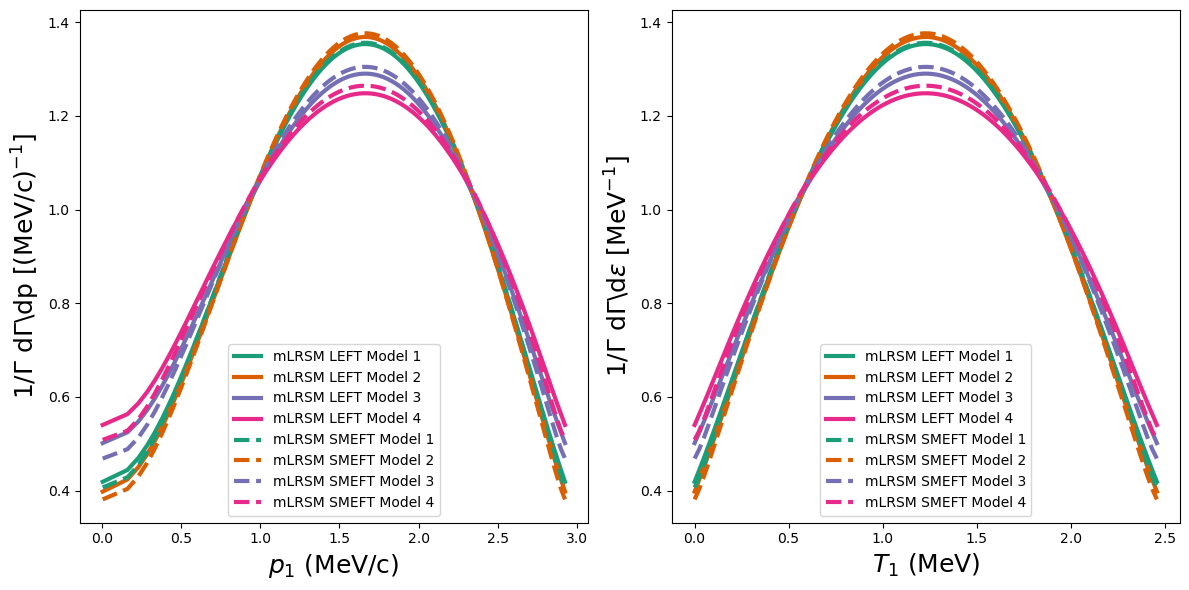

In [21]:
fig = plt.figure(figsize=(12, 6))

colors = [cmap(i) for i in range(4)]
colors = colors + colors

for m in range(len(Models)):

    if (m <4):
        rho_spec_vec = Models[m].spectrum(ebar_vec,isotope="136Xe")
        name = f"mLRSM LEFT Model {m+1}"
        linestyle="-"
    else:
        rho_spec_vec = Models[m].spectrum(ebar_vec)
        name = f"mLRSM SMEFT Model {m+1-4}"
        linestyle="--"
    

    plt.subplot(121)
    plt.plot(p_vec, rho_spec_vec/sum(rho_spec_vec)*nbins, linewidth=3,label = name, color = colors[m],linestyle=linestyle)
    plt.xlabel(r'$p_1$ (MeV/c)', fontsize=18)
    plt.ylabel("1/$\Gamma$ d$\Gamma$\dp [(MeV/c)$^{-1}$]", fontsize=18)
    plt.legend()

    plt.subplot(122)
    plt.plot(t_vec, rho_spec_vec/sum(rho_spec_vec)*nbins, linewidth=3,label = name, color = colors[m],linestyle=linestyle)
    plt.xlabel(r'$T_1$ (MeV)', fontsize=18)
    plt.ylabel("1/$\Gamma$ d$\Gamma$\d$\epsilon$ [MeV$^{-1}$]", fontsize=18)
    plt.legend()

    plt.tight_layout()
    

In [22]:
# Find maximum, for random generation along y axis for accept-reject method
rho_spec_max = np.max(rho_spec_vec)
print("rho_spec_max = ", rho_spec_max)

p_max = p_fun(Q)
print(p_max)
t_max = Q
print(t_max)

rho_spec_max =  1.938275535902318e-30
2.9246777310482606
2.457984


In [23]:
rho_spec_fun = interp1d(t_vec, rho_spec_vec, kind='linear', fill_value=(rho_spec_vec[0],rho_spec_vec[-1]), bounds_error=False)

In [24]:
t1_vec = np.zeros(nevts)
t2_vec = np.zeros(nevts)

ievt = 0

while ievt < nevts:

    t1 = np.random.uniform(low = 0., high = t_max)
    p1 = p_fun(t1)
    t2 = Q - t1
    p2 = p_fun(t2)
    
    if (t1 < 0 or t2 < 0 or t1 > t_max or t2 > t_max):
        print(t1,t2)
    
    f = np.random.uniform(low=0., high=rho_spec_max)  
 
    if (f < rho_spec_fun(t1)):
        t1_vec[ievt] = t1 # MeV units
        t2_vec[ievt] = t2 # MeC units
        ievt += 1
        
print("# accepted = ", ievt, " over ", nevts)

# accepted =  100000  over  100000


### Second, sampling of electron angular distributions

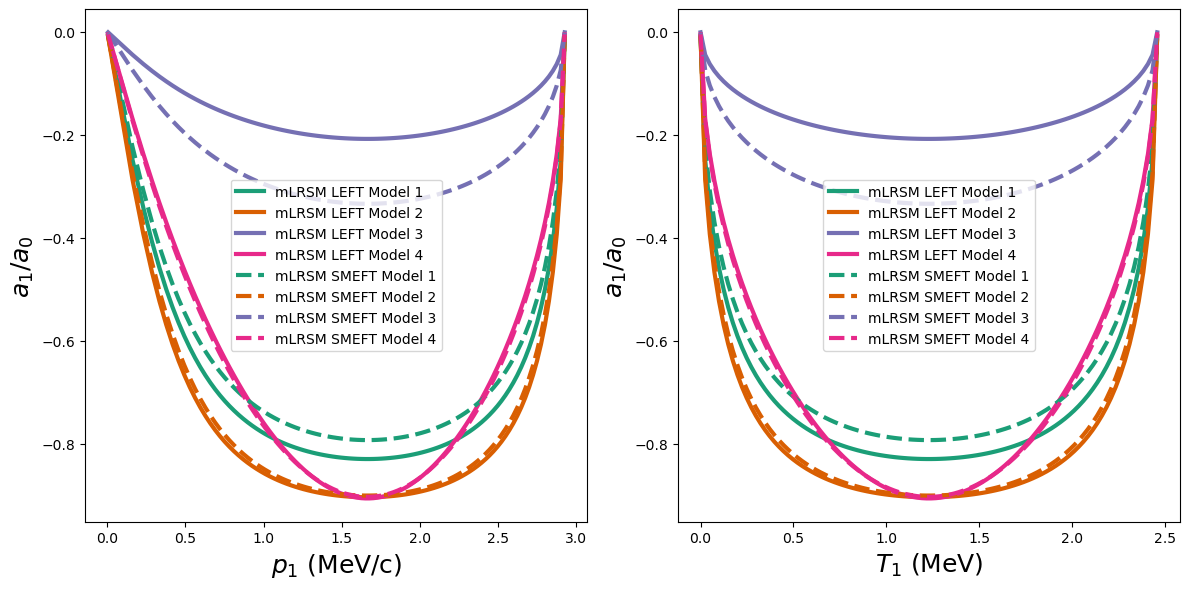

In [25]:
fig = plt.figure(figsize=(12, 6))

for m in range(len(Models)):

    if (m <4):
        rho_angle_vec = Models[m].angular_corr(ebar_vec,isotope="136Xe")
        name = f"mLRSM LEFT Model {m+1}"
        linestyle="-"
    else:
        rho_angle_vec = Models[m].angular_corr(ebar_vec)
        name = f"mLRSM SMEFT Model {m+1-4}"
        linestyle="--"

    plt.subplot(121)
    plt.plot(p_vec, rho_angle_vec, linewidth=3,label = name, color = colors[m],linestyle=linestyle)
    plt.xlabel(r'$p_1$ (MeV/c)', fontsize=18)
    plt.ylabel("$a_1/a_0$", fontsize=18)
    plt.legend()

    plt.subplot(122)
    plt.plot(t_vec, rho_angle_vec, linewidth=3,label = name, color = colors[m],linestyle=linestyle)
    plt.xlabel(r'$T_1$ (MeV)', fontsize=18)
    plt.ylabel("$a_1/a_0$", fontsize=18)
    plt.legend()

    plt.tight_layout()